## Frozen Lake Dynamic Programming Example
Policy evaluation / iteration on the openai gym FrozenLake enironment. 

In [11]:
import gym
import numpy as np

The Frozen Lake environment is a 4×4 grid which contain four possible areas  — Safe (S), Frozen (F), Hole (H) and Goal (G).

Actions are:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [15]:
env = gym.make('FrozenLake-v0')
print("Action Count:", env.action_space.n)
print("Observation Count:", env.observation_space.n)
env.render()

Action Count: 4
Observation Count: 16
Action Count: 16

SFFF
FHFH
FFFH
HFFG


In [57]:
env.env.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

## Policy Evaluation / Iteration
Converge to the true value function for a given policy π. We will define a function that returns the required value function.

In [41]:
def policy_evaluation(policy, environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9, debug=False):
    # Number of evaluation iterations
    evaluation_iterations = 1
    # Initialize a value function for each state as zero
    V = np.zeros(environment.nS)
    # Repeat until change in value is below the threshold
    for i in range(int(max_iterations)):
        # Initialize a change of value function as zero
        delta = 0
        # Iterate though each state
        for state in range(environment.nS):
            # We caculate the new value for v. This is the Bellman expectation equation.
            v = 0
            # Try all possible actions which can be taken from this state
            for action, action_probability in enumerate(policy[state]):
                # Check how good next state will be
                for state_probability, next_state, reward, terminated in environment.P[state][action]:
                    # Calculate the expected value
                    v += action_probability * state_probability * (reward + discount_factor * V[next_state])

            # Calculate the absolute change of value function
            delta = max(delta, np.abs(V[state] - v))
            # Update value function
            V[state] = v
        evaluation_iterations += 1

        if i in [0,1,2,3,10,20,30,50] and debug:
            print("\nIteration:", i)
            print(np.reshape(V, (4,4)))
        
        # Terminate if value change is insignificant
        if delta < theta:
            print(f'\nPolicy evaluated in {evaluation_iterations} iterations.')
            if debug:
                print(np.reshape(V, (4,4)))
            return V

Here we will evaluate the current policy to determine the value function and show the steps from a sample policy evaluation.

In [43]:
policy = np.ones([env.observation_space.n, env.action_space.n])  / env.env.nA
V = policy_evaluation(policy, env.env, debug=True), (4,4)


Iteration: 0
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.25 0.  ]]

Iteration: 1
[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.      0.0625  0.     ]
 [0.      0.0625  0.34375 0.     ]]

Iteration: 2
[[0.         0.         0.         0.        ]
 [0.         0.         0.015625   0.        ]
 [0.         0.03125    0.09765625 0.        ]
 [0.         0.109375   0.38769531 0.        ]]

Iteration: 3
[[0.         0.         0.00390625 0.00097656]
 [0.         0.         0.02539062 0.        ]
 [0.0078125  0.05371094 0.11669922 0.        ]
 [0.         0.13769531 0.41052246 0.        ]]

Iteration: 10
[[0.00852188 0.00840428 0.01835643 0.00862103]
 [0.01322431 0.         0.03977938 0.        ]
 [0.0329189  0.08697215 0.14120536 0.        ]
 [0.         0.17481267 0.43852198 0.        ]]

Iteration: 20
[[0.01352453 0.01139001 0.02077383 0.01034734]
 [0.01604704 0.         0.04069592 0.        ]
 [0.03470911 0.0881

Policy Improvement part will return a tuple (policy,V) which is the optimal policy matrix and value function for each state.

In [50]:
def one_step_lookahead(environment, state, V, discount_factor):
    action_values = np.zeros(environment.nA)
    for action in range(environment.nA):
        for probability, next_state, reward, terminated in environment.P[state][action]:
            action_values[action] += probability * (reward + discount_factor * V[next_state])
    return action_values

In [54]:
def policy_iteration(environment, discount_factor=1.0, max_iterations=1e9):
    # Start with a random policy (not strictly random as n.argmax takes the first argumant if multiple are similar)
    #num states x num actions / num actions
    policy = np.ones([environment.nS, environment.nA]) / environment.nA
    # Initialize counter of evaluated policies
    evaluated_policies = 0
    # Repeat until convergence or critical number of iterations reached
    for i in range(int(max_iterations)):
        print(policy)
        stable_policy = True
        # Evaluate current policy
        V = policy_evaluation(policy, environment, discount_factor=discount_factor)
        # Go through each state and try to improve actions that were taken (policy Improvement)
        for state in range(environment.nS):
            # Choose the best action in a current state under current policy
            current_action = np.argmax(policy[state])
            # Look one step ahead and evaluate if current action is optimal
            # We will try every possible action in a current state
            action_value = one_step_lookahead(environment, state, V, discount_factor)
            # Select a better action
            best_action = np.argmax(action_value)
            # If action changed
            if current_action != best_action:
                stable_policy = False
                # Greedy policy update
                policy[state] = np.eye(environment.nA)[best_action]
                
        evaluated_policies += 1
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
        if stable_policy:
            print(f'Evaluated {evaluated_policies} policies.')
            return policy, V

## Value Iteration

In [55]:
def value_iteration(environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
        # Initialize state-value function with zeros for each environment state
        V = np.zeros(environment.nS)
        for i in range(int(max_iterations)):
                # Early stopping condition
                delta = 0
                # Update each state
                for state in range(environment.nS):
                        # Do a one-step lookahead to calculate state-action values
                        action_value = one_step_lookahead(environment, state, V, discount_factor)
                        # Select best action to perform based on the highest state-action value
                        best_action_value = np.max(action_value)
                        # Calculate change in value
                        delta = max(delta, np.abs(V[state] - best_action_value))
                        # Update the value function for current state
                        V[state] = best_action_value
                        # Check if we can stop
                if delta < theta:
                        print(f'Value-iteration converged at iteration#{i}.')
                        break

        # Create a deterministic policy using the optimal value function
        policy = np.zeros([environment.nS, environment.nA])
        for state in range(environment.nS):
                # One step lookahead to find the best action for this state
                action_value = one_step_lookahead(environment, state, V, discount_factor)
                # Select best action based on the highest state-action value
                best_action = np.argmax(action_value)
                # Update the policy to perform a better action at a current state
                policy[state, best_action] = 1.0
        return policy, V

## Play Episodes
Play episodes for both policy and value iteration.

In [56]:
def play_episodes(environment, n_episodes, policy):
        wins = 0
        total_reward = 0
        for episode in range(n_episodes):
                terminated = False
                state = environment.reset()
                while not terminated:
                        # Select best action to perform in a current state
                        action = np.argmax(policy[state])
                        # Perform an action an observe how environment acted in response
                        next_state, reward, terminated, info = environment.step(action)
                        # Summarize total reward
                        total_reward += reward
                        # Update current state
                        state = next_state
                        # Calculate number of wins over episodes
                        if terminated and reward == 1.0:
                                wins += 1
        average_reward = total_reward / n_episodes
        return wins, total_reward, average_reward

# Number of episodes to play
n_episodes = 10000
# Functions to find best policy
solvers = [('Policy Iteration', policy_iteration),
           ('Value Iteration', value_iteration)]
for iteration_name, iteration_func in solvers:
        # Load a Frozen Lake environment
        environment = gym.make('FrozenLake-v0')
        # Search for an optimal policy using policy iteration
        policy, V = iteration_func(environment.env)
        # Apply best policy to the real environment
        wins, total_reward, average_reward = play_episodes(environment, n_episodes, policy)
        print(f'{iteration_name} :: number of wins over {n_episodes} episodes = {wins}')
        print(f'{iteration_name} :: average reward over {n_episodes} episodes = {average_reward} \n\n')

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Policy evaluated in 66 iterations.
[[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]

Policy evaluated in 170 iterations.
[[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0. 

We observe that value iteration has a better average reward and higher number of wins when it is run for 10,000 episodes.

# Alternate value iteration example
https://github.com/OneRaynyDay/FrozenLakeMDP/blob/master/frozenlake.py

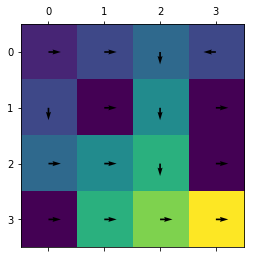

In [60]:
"""
Let's use Value Iteration to solve FrozenLake!

Setup
-----
We start off by defining our actions:
A = {move left, move right...} = {(0,1),(0,-1),...}
S = {(i,j) for 0 <= i,j < 4}
Reward for (3,3) = 1, and otherwise 0.
Probability distribution is a 4x(4x4) matrix of exactly the policy.
We have pi(a|s), where a in A, and s in S.

Problem formulation : https://gym.openai.com/envs/FrozenLake-v0/

Algorithm
---------
Because our situation is deterministic for now, we have the value iteration eq:

v <- 0 for all states.
v_{k+1}(s) = max_a (\sum_{s',r} p(s',r|s,a) (r + \gamma * v_k(s'))

... which decays to:

v_{k+1}(s = max_a (\sum_{s'} 1_(end(s')) + \gamma * v_k(s'))

Because of our deterministic state and the deterministic reward.
"""
import numpy as np
import random
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline  

N = 4
v = np.zeros((N, N), dtype=np.float32) # Is our value vector.
ITER = 1000
A = [(0,1),(0,-1),(1,0),(-1,0)]

# If you're feeling adventurous, make your own MAP
MAP = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]

def proj(n, minn, maxn):
    """
    projects n into the range [minn, maxn). 
    """
    return max(min(maxn-1, n), minn)

def move(s, tpl, stochasticity=0):
    """
    Set stochasticity to any number in [0,1].
    This is equivalent to "slipping on the ground"
    in FrozenLake.
	"""
    if MAP[s[0]][s[1]] == 'H': # Go back to the start
        return (0,0)
    if np.random.random() < stochasticity:
        return random.choice(A)
    return (proj(s[0] + tpl[0], 0, N), proj(s[1] + tpl[1], 0, N))

def reward(s):
    return MAP[s[0]][s[1]] == 'G'
    
def run_with_value(v, gamma=0.9):
    old_v = v.copy()
    for i in range(N):
        for j in range(N):
            best_val = 0
            for a in A:
                new_s = move((i,j), a)
                best_val = max(best_val, gamma * old_v[new_s])
            v[i,j] = best_val + reward((i,j))
    return old_v

# Extracting policy from v:
def pi(s, v):
    cur_best = float("-inf")
    cur_a = None
    for a in A:
        val = v[move(s, a, stochasticity=0)]
        if val > cur_best:
            cur_a = a
            cur_best = val
    return cur_a

np.random.seed(0)
random.seed(0)
# Performing Value Iteration
old_v = run_with_value(v)
for i in range(ITER):
    old_v = run_with_value(v)

# Plotting a nice arrow map.
action_map = np.array([
    [pi((i,j), v) for j in range(N)] for i in range(N)])
Fx = np.array([ [col[1] for col in row] for row in action_map ])
Fy = np.array([ [-col[0] for col in row] for row in action_map ])
plt.matshow(v) 
plt.quiver(Fx,Fy)
plt.show()